Fama (1970) introduced efficient market hypothesis (EMH), stating the prices of securities fully reflect available information. Therefore, investors buying securities in an efficient market should expect to obtain an equilibrium rate of return. Later he introduced three different form of market efficiency: weak, semi-strong, and strong. Anomalies are empirical results that seem to be inconsistent with maintained theories of asset-pricing behavior. One class of market anomalies is seasonality and changes in market trend during different seasons. Seasonality in stock returns is a closely related to week-form of market efficiency. There are multiple seasonality effects (aka calendar effects):
* Weekend effect
* Monthly effect 
* Holidays effect

Here, we attempt to explore monthly change in stock market returns. The following table demonstrates market return at each month for the past 300 plus years!(Source: [SeekingAlpha](https://seekingalpha.com/article/1183461-seasonal-patterns-in-stock-markets-319-years-of-evidence))


| Average Return % | 316 years  | 82 years|	50 years|14 years|
|------|------|------|------|------|
|      | 1693-2009|1929-2011|	1961-2011|	1999-2012|
|January|	0.69|	1.0|	1.2	|-1.6|
|February|	0.09|	0.0|	0.0|	-1.3|
|March|	-0.03|	0.4|	1.1|	2.7|
|April|	0.49|	1.4	|2|	2.7|
|May|	0.02|	-0.2|	-0.1|	-0.8|
|June|	-0.12|	0.5|	-0.6|	-1.22|
|July|	-0.31|	1.5|	0.9	|0.34|
|August|	0.44|	0.8|	0.2|	0.39|
|September|	-0.49|	-1.3|	-0.8	|-1.28|
|October|	-0.5|	0.0|	0.5|	1.32|
|November|	0.35|	0.8|	1.2	|1.2|
|December	|0.81|	1.5|	1.5	|2.6|
|Winter|	2.42|	5.20|	7.20|	6.36|
|Summer|	-0.96|	1.28|	0.09|	-1.27|
|Whole Year|	1.44|	6.55|	7.29|	5.01|
|Difference Winter-Summer|	3.38|	3.92	|7.11|	7.63|



First, we are going to look at SPY calendar anomaly and observe possible trend changes in every month. Data available for this analysis starts from 2012 so we have 16 years of history to study. We are going to calculate monthly return of each year and plot with box plot.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fix_yahoo_finance as yf  

start = '2002-01-01'
end = '2018-01-01'
Symbol='SPY'
Data = yf.download(Symbol, start, end)
SPY=Data['Adj Close']

[*********************100%***********************]  1 of 1 downloaded


In [19]:

r = SPY.pct_change()
Monthly_Returns = r.groupby([r.index.year.rename('year'), r.index.month.rename('month')]).mean()

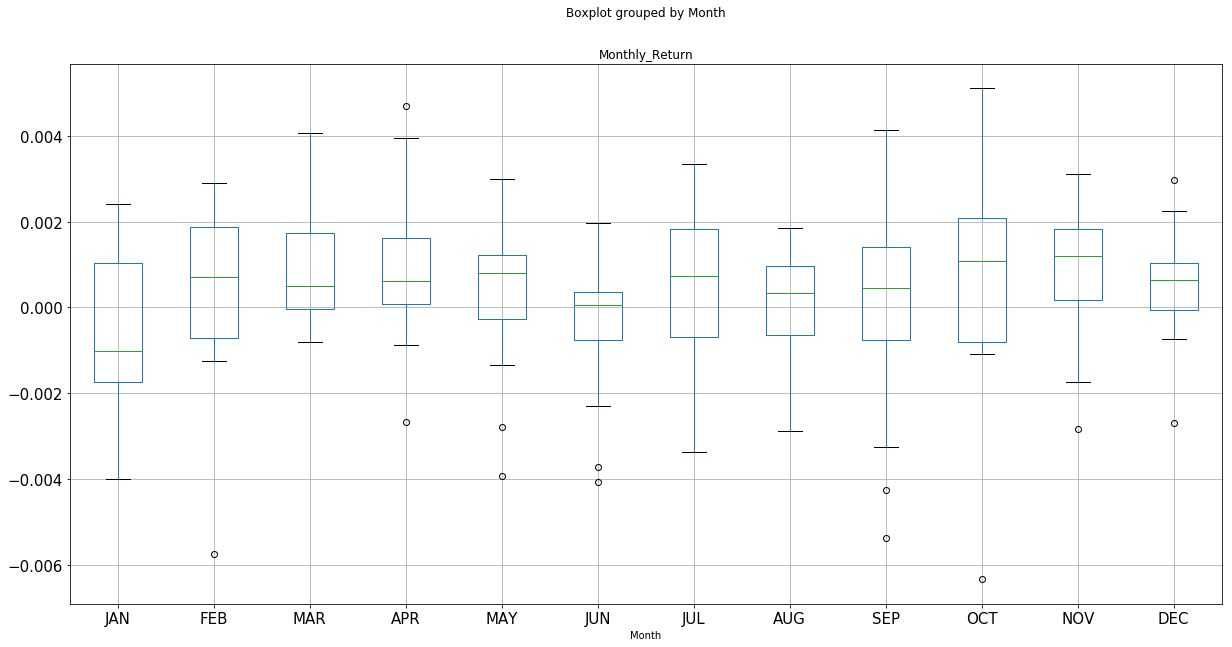

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10



Monthly_Returns_List=[]
for i in range(len(Monthly_Returns)):
    Monthly_Returns_List.append({'Year':Monthly_Returns.index[i][0],'Month':Monthly_Returns.index[i][1],
                                 'Monthly_Return': Monthly_Returns[i] })
Monthly_Returns_List=pd.DataFrame(Monthly_Returns_List,
                                  columns=('Year','Month','Monthly_Return'))


Monthly_Returns_List.boxplot(column='Monthly_Return', by='Month')
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ax.set_xticklabels(labels)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Observations:
* Overall market return trend exhibits a wave like pattern: market returns seem to increase from January to April followed by decrease in average returns in May and June. August to December exhibits steady increase in market returns.   
* Highest range of return (high to low range of  box plot) in the past 16+ years occured in January, July, and August.
* October demonstrates low donwside trade probability as low part of the box plot is closely situated outside the first quantile of the data. Therefore, it might provide good opportunity for investor to get in market or add to their investments. However, proper backtesting is needed to prove this hypothesis.
* Months of June and December provide the smallest quarterfinal range (IQR). Coincidentally, the aforementioned months are half year and end of the trading yea

Now we will utilize the Augmented Dickey-Fuller Test for stationarity. The null hypothesis states that large p values indicate non-stationarity and smaller p values indicate stationarity. (We will be using 0.05 as selected alpha value.)

In [23]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(SPY)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.010060
p-value: 0.998686
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


As suspected, ADF test revealed the time series data (SPY stock data) are non stationary meaning time series is a stochastic process whose unconditional joint probability distribution changes when shifted in time. Now we know our time series is non staitionary, we attempt to exploit seasonality trends using time series decomposition. 

We shall think of the time series $y_t$ as comprising three components: a seasonal component, a trend-cycle component (containing both trend and cycle), and a remainder component (containing anything else in the time series). For example, if we assume an additive model, then we can write:
$$y_t=S_t+T_t+E_t$$
where ytyt is the data at period $t$, $S_t$ is the seasonal component at period $t$, $T_t$ is the trend-cycle component at period $t$ and $E_t$ is the remainder (or irregular or error) component at period $t$. Alternatively, a multiplicative model would be written as
$$y_t=S_t×T_t×E_t$$

For more detailed information visit [here](https://www.otexts.org/fpp/6/1)

In this notebook I am using additive decomposition model to extract seasonal model. In order to calculate seasonal effect, I used frequency decomposition of 252 meaning, trend is repeated every 252 days (5 trading days and 9 holidays results in 252 trading day).


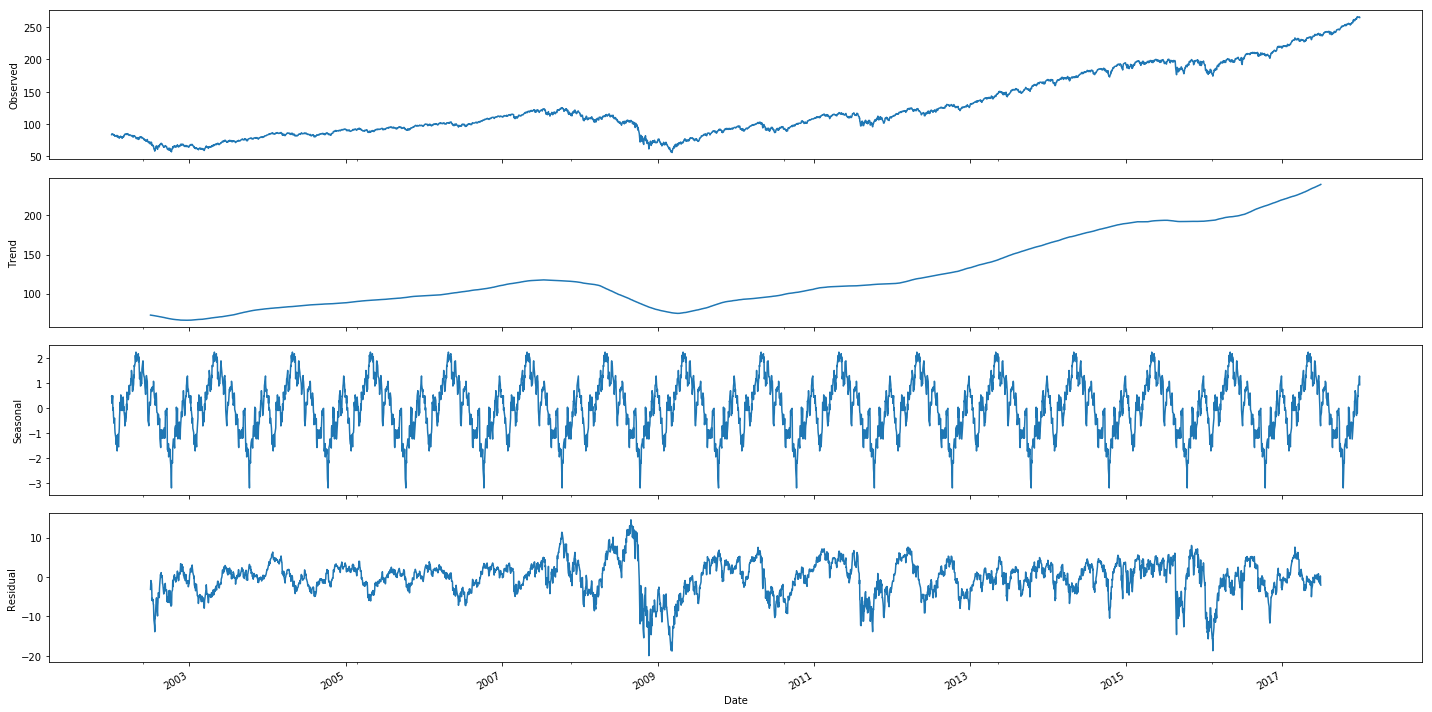

In [24]:
import statsmodels.api
import statsmodels as sm

res = sm.tsa.seasonal.seasonal_decompose(SPY,model='additive', freq=252)
resplot = res.plot()


As it can be seen from the above chart, overall trend of the market was increasing with the downward trend in 2008–2009. The seasonal trend repeating every year indicate valley and peak. Now, we attempt to isolate this trend and inspect it further:

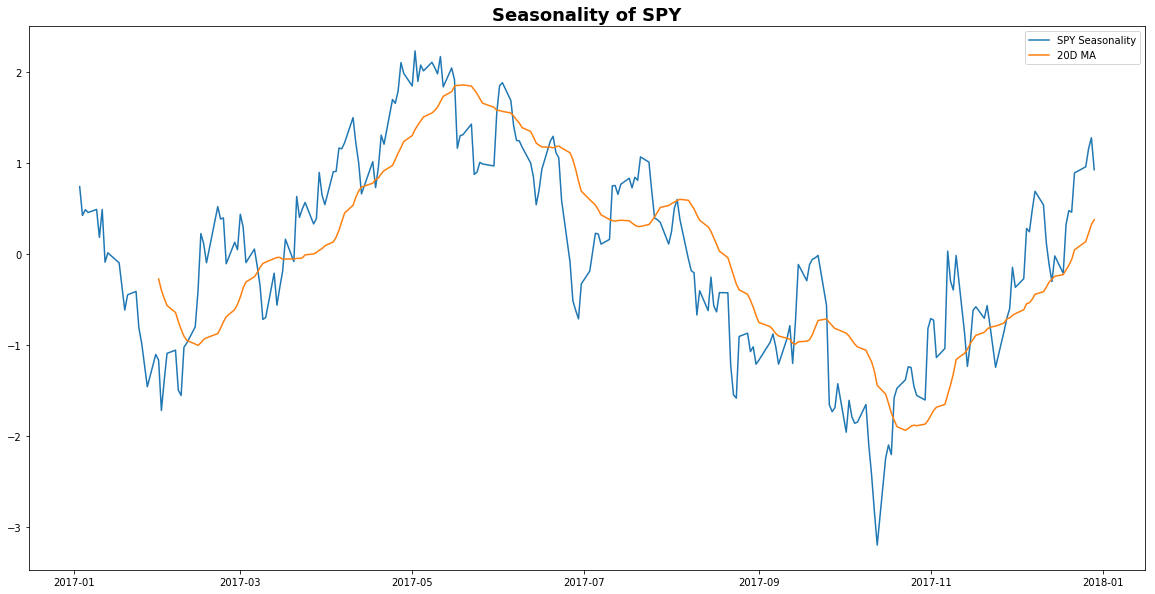

In [31]:
SPY_Seasonality=res.seasonal[res.seasonal.index.year == 2017]
MA1=SPY_Seasonality.rolling(window=20).mean()
plt.plot(SPY_Seasonality, label='SPY Seasonality')
plt.plot(MA1, label='20D MA')
plt.title("Seasonality of SPY", fontsize=18, fontweight='bold')
plt.legend()
plt.show()

Observations:
* As it can be seen from the above seasonality chart, the seasonality trend is like a wave with major high happening around May and major lows happening around October.
* Market expands from beginning of the year to Spring, then it follows by a period of contraction to mid fall.
* The seasonality trend reveals change in expectation of market performance during the year.


Now we isolated seasonality trend we can, adjust market trend in regard to seasonality. Since we used additive model to identify seasonality, we can simply deduct seasonality from stock data (SPY) and adjust for seasonality. In periods where market has strong bull or bear (upward or downward) trends, seasonality effects might be too weak to observe. However, if market exhibits range bound behavior it, such effect can be more evident. Here, we will look at 2017 data (strong bull market) and 2015 data (sideways behavior)

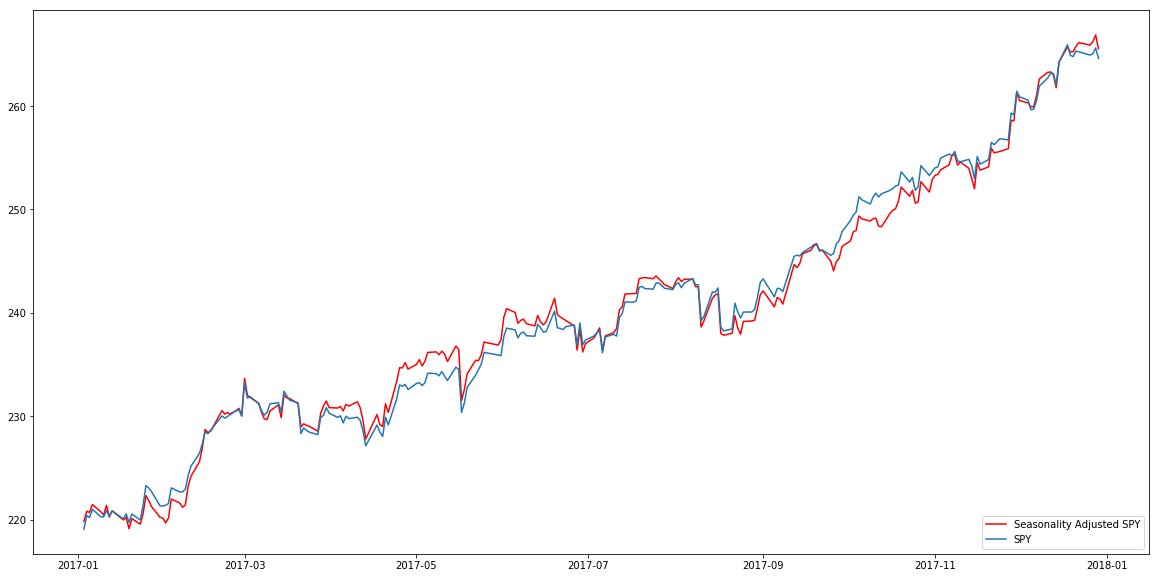

In [32]:
plt.plot(SPY[SPY.index.year == 2017]+SPY_Seasonality,color='red',label='Seasonality Adjusted SPY');
plt.plot(SPY[SPY.index.year == 2017],label='SPY')
plt.legend(loc=4)
plt.show()

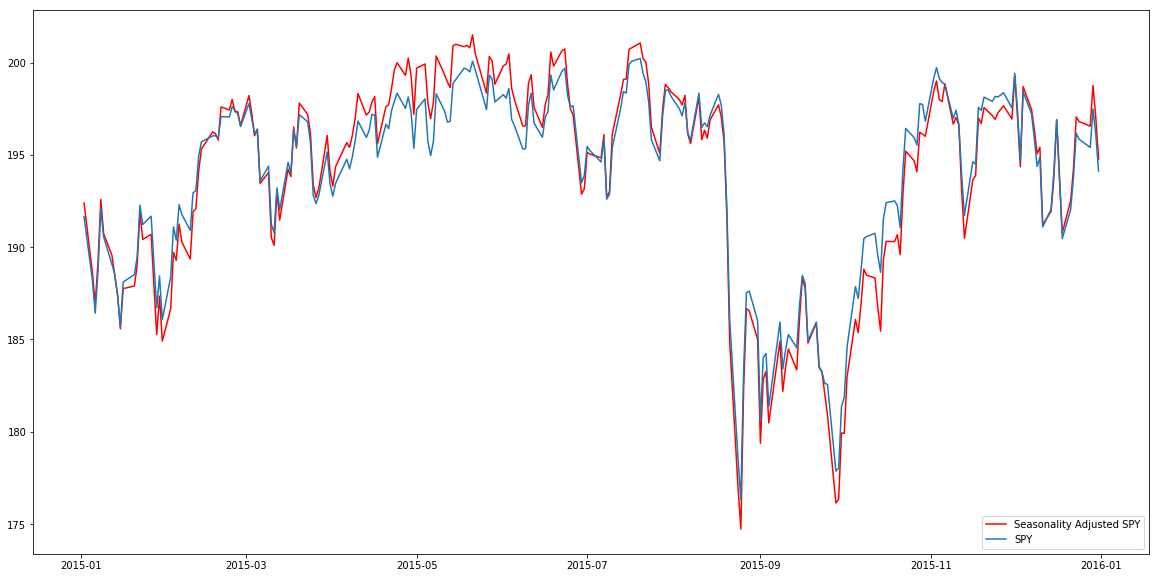

In [33]:
plt.plot(SPY[SPY.index.year == 2015]+res.seasonal[res.seasonal.index.year == 2015],color='red',label='Seasonality Adjusted SPY');
plt.plot(SPY[SPY.index.year == 2015],label='SPY')
plt.legend(loc=4)
plt.show()

Now we can simply test the return of a simple strategy based on seasonality. We are going to buy SPY in October and sell the entire holdings in May or simply comparing return of SPY from October of each year to May of next year. 

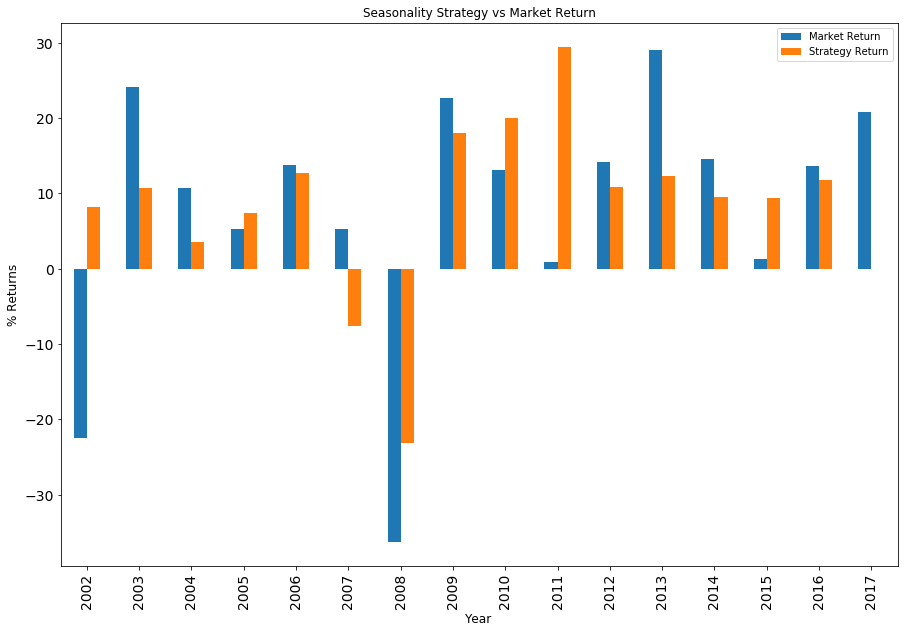

In [34]:
import datetime
Min_Month=SPY_Seasonality.idxmin().month
Max_Month=SPY_Seasonality.idxmax().month

Index=SPY.index
Years = list(set(Index.year))
Years.sort()

Returns = d = {'Market Return' : pd.Series(index=Years),'Strategy Return' : pd.Series( index=Years)}
Returns = pd.DataFrame(Returns)

for index, row in Returns.iterrows():
    Data=SPY[SPY.index.year == index]
    row['Market Return']=((Data.iloc[-1]-Data.iloc[0])*100/Data.iloc[0])
    if index<Years[-1]:
        # purchase at first day of the min month (this year)
        Purchase=SPY.loc[(SPY.index.year==index) & (SPY.index.month==Min_Month)][0]
        # sell at the first day of max month (next year)
        Sell=SPY.loc[(SPY.index.year==index+1) & (SPY.index.month==Max_Month)][0]
        row['Strategy Return']=(Sell-Purchase)*100/Purchase

ax = Returns[['Market Return','Strategy Return']].plot(kind='bar', title ="Seasonality Strategy vs Market Return", figsize=(15, 10), legend=True, fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("% Returns", fontsize=12)
plt.show()

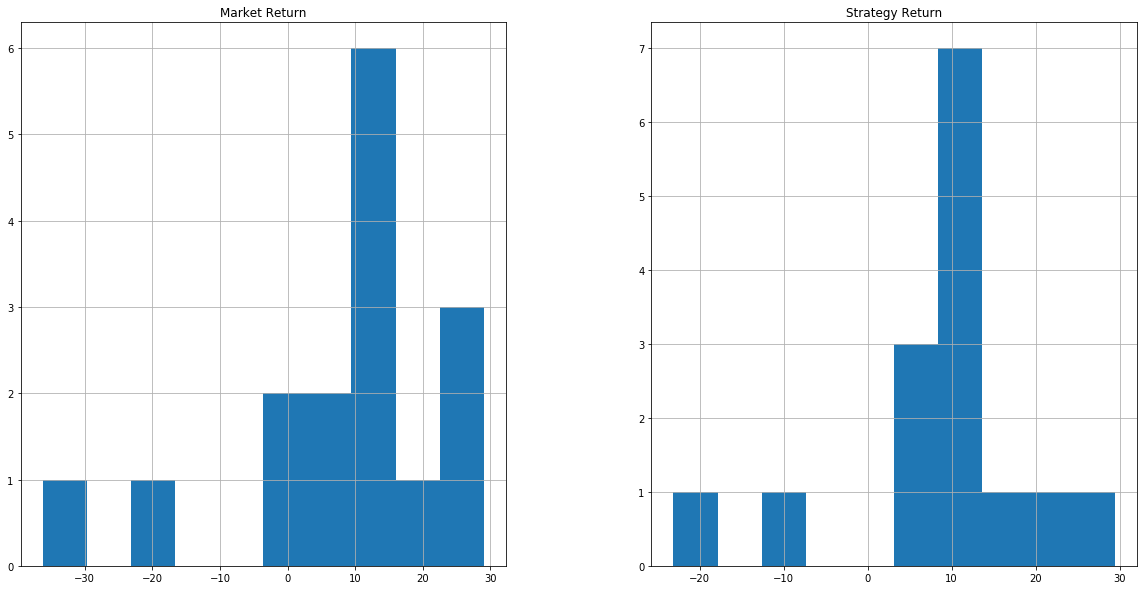

In [35]:
Returns.hist();

Looking at returns of our strategy we can see; this strategy is not as profitable as simply buying and holding for entire year. During market crash of 2008, this strategy lost less money than average market return. However, this might be due to start month of market crash (further analysis is required). One should note that this strategy is extremely simple without considering proper entry and exit point within each month. Therefore, in order to fully understand the profitability and risk of this strategy, in depth analysis is required which is outside the scope of this article.

Now we will analyze different market sectors and their respective seasonality and measure the correlation to SPY seasonality:

In [106]:
Sectors={'XLB','XLY','XLF','XLP','XLV','XLU','XLE','XLI','XLK'}
Sectors_Data=pd.DataFrame(columns=Sectors)

In [113]:
for item in Sectors:
    Data = yf.download(item, start, end)
    Sectors_Data[item]=Data['Adj Close']


[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [114]:
df_ = pd.DataFrame(index=SPY_Seasonality.index, columns=Sectors)

for column in df_:
    Sectors_res = sm.tsa.seasonal.seasonal_decompose( Sectors_Data[column],model='additive', freq=252)
    Seasonality=Sectors_res.seasonal[Sectors_res.seasonal.index.year == 2017]
    df_[column]=Seasonality

C:\Users\anejad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  # Remove the CWD from sys.path while we load stuff.


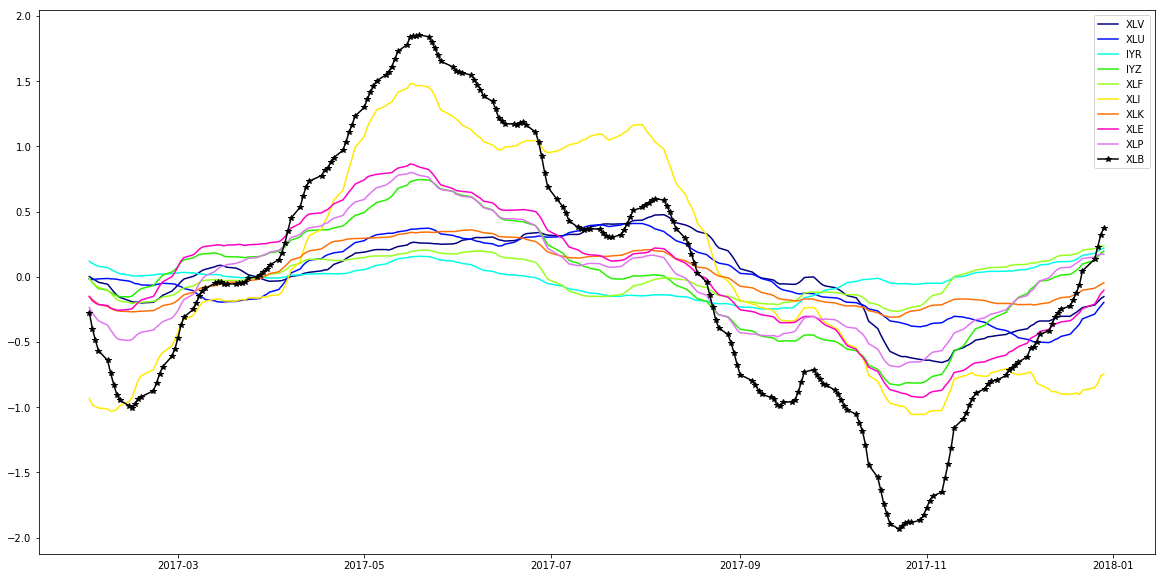

In [115]:
import scipy.stats as ss

Summary=[]
Legend={'XLB','XLY','XLF','IYR','XLP','XLV','XLU','IYZ','XLE','XLI','XLK'}
NUM_COLORS = len(Sectors)

cm = plt.get_cmap('gist_ncar')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for column in df_:
    ax.plot(df_[column].rolling(window=20).mean())
    Summary.append({'Sector': column, 'Min': np.min(df_[column]), 'Max': np.max(df_[column]),\
                   'Range':np.max(df_[column])-np.min(df_[column]),'Std':np.std(df_[column]), 'Corr to SPY Seasonality': ss.spearmanr(SPY_Seasonality, df_[column])[0] })

ax.plot(SPY_Seasonality.rolling(window=20).mean(), color='black', linestyle='-',marker='*')
plt.legend(Legend)
plt.show()
Summary=pd.DataFrame(Summary, columns=('Sector','Min','Max','Range','Std','Corr to SPY Seasonality'))

SPY seasonality in the above picture overlaied with black line.

I used Spearman Rank Correlation to identify correlation of seasonality of different market sectors to seasonality of market itself. As it can be seen from the tables below, consumer discretionary has highest correlation to market seasonality and real estate sector has the least seasonality correlation to market. 

In [116]:
Summary.sort_values('Corr to SPY Seasonality', inplace=True)
Summary

,Sector,Min,Max,Range,Std,Corr to SPY Seasonality
2,XLF,-0.288758,0.327809,0.616566,0.141716,0.456077
1,XLU,-0.765632,0.546009,1.311640,0.294055,0.738812
0,XLV,-1.079326,0.625209,1.704535,0.335776,0.741101
4,XLK,-0.484677,0.383576,0.868254,0.188623,0.758345
5,XLE,-1.808995,1.821685,3.630679,0.885122,0.780646
6,XLP,-0.420762,0.460572,0.881334,0.230093,0.916927
7,XLB,-1.183580,1.050584,2.234164,0.506791,0.922245
3,XLI,-1.154390,0.941885,2.096276,0.435831,0.932122
8,XLY,-0.954613,1.056050,2.010662,0.436116,0.952566


The cumulative histogram of seasonality of selected market sectors are listed below. 

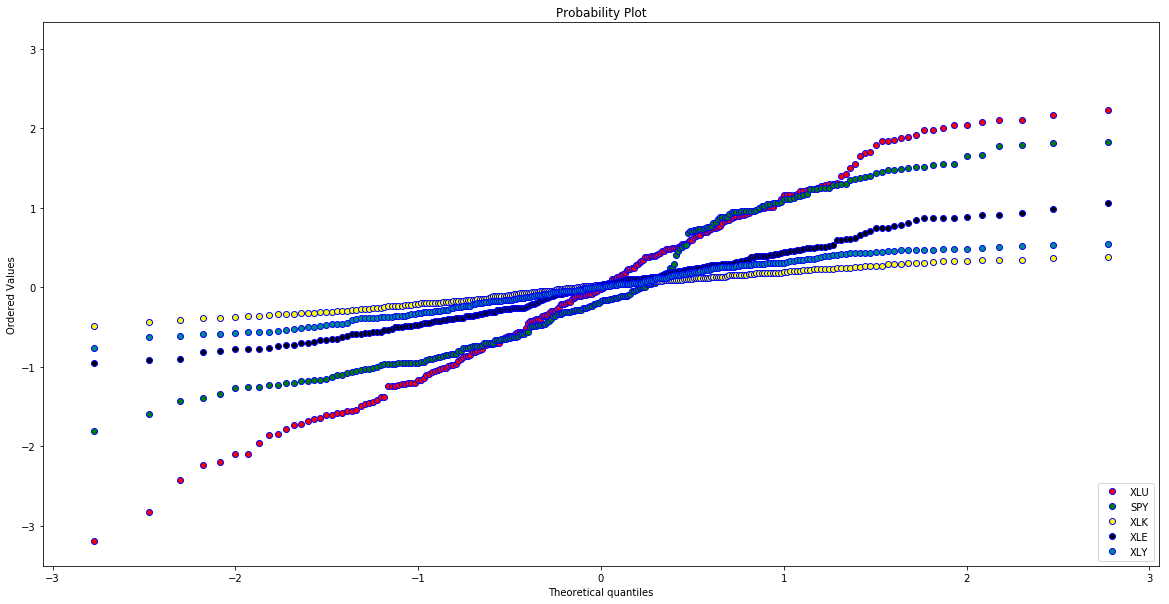

In [117]:
from scipy import stats
plt.close(fig)
fig = plt.figure()
ax = fig.add_subplot(111)

stats.probplot(SPY_Seasonality, plot=ax);
stats.probplot(df_['XLE'], plot=ax);
stats.probplot(df_['XLK'], plot=ax);
stats.probplot(df_['XLY'], plot=ax);
stats.probplot(df_['XLU'], plot=ax);


ax.get_lines()[0].set_markerfacecolor('red')
ax.get_lines()[2].set_markerfacecolor('green')
ax.get_lines()[4].set_markerfacecolor('yellow')
ax.get_lines()[6].set_markerfacecolor('black')
ax.get_lines()[8].set_markerfacecolor('darkcyan')

ax.get_lines()[1].remove()
ax.get_lines()[2].remove()
ax.get_lines()[3].remove()
ax.get_lines()[4].remove()
ax.get_lines()[5].remove()
ax.legend({'SPY','XLE','XLK','XLY','XLU'},loc=4);

We can use empirical time series model to identify the effect of each month. The model is defined as below:
$$ R=\beta+\alpha_{jan}  \times r_{jan}+\alpha_{feb}  \times r_{feb}+...\alpha_{nov}  \times r_{nov}$$

All we need to do is to find returns of each month then use regression analysis to find the coefficients. $\beta$ in this case can be considered as December return

In [119]:
r = SPY.pct_change()


g=r.groupby((r.index.year.rename('year'), r.index.month.rename('month'))).sum()
Monthly_Data=g.unstack()
Yearly_Data=r.groupby((r.index.year)).sum()
labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
Monthly_Data.columns=labels

C:\Users\anejad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  after removing the cwd from sys.path.


In [120]:
import statsmodels.api as sm

X = Monthly_Data[['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV']]
    
X = sm.add_constant(X)

model11 = sm.OLS(Yearly_Data, X).fit()

In [121]:
model11.summary()

C:\Users\anejad\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     65.78
Date:                Fri, 14 Sep 2018   Prob (F-statistic):           0.000531
Time:                        21:42:53   Log-Likelihood:                 47.550
No. Observations:                  16   AIC:                            -71.10
Df Residuals:                       4   BIC:                            -61.83
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0268      0.025     -1.068      0.346      -0.097       0.043
JAN            1.0971      0.258      4.252      0.013       0.381       1.813
FEB            1.8115      0.578      3.133      0.035       0.206       3.417
MAR            1.1242      0.423      2.655      0.057      -0.051       2.300
APR            2.5255      0.702      3.599      0.023       0.577       4.474
MAY            0.6763      0.308      2.194      0.093      -0.180       1.532
JUN            0.6524      0.437      1.492      0.210      -0.562       1.867
JUL            0.2033      0.645      0.315      0.768      -1.588       1.994
AUG            0.3904      0.517      0.756      0.492      -1.044       1.825
SEP            1.3751      0.258      5.336      0.006       0.660       2.091
OCT            0.4391      0.319      1.377      0.240      -0.446       1.324
NOV            2.2764      0.743      3.064      0.038       0.214       4.339
==============================================================================
Omnibus:                        1.998   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                0.819
Skew:                           0.546   Prob(JB):                        0.664
Kurtosis:                       3.190   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

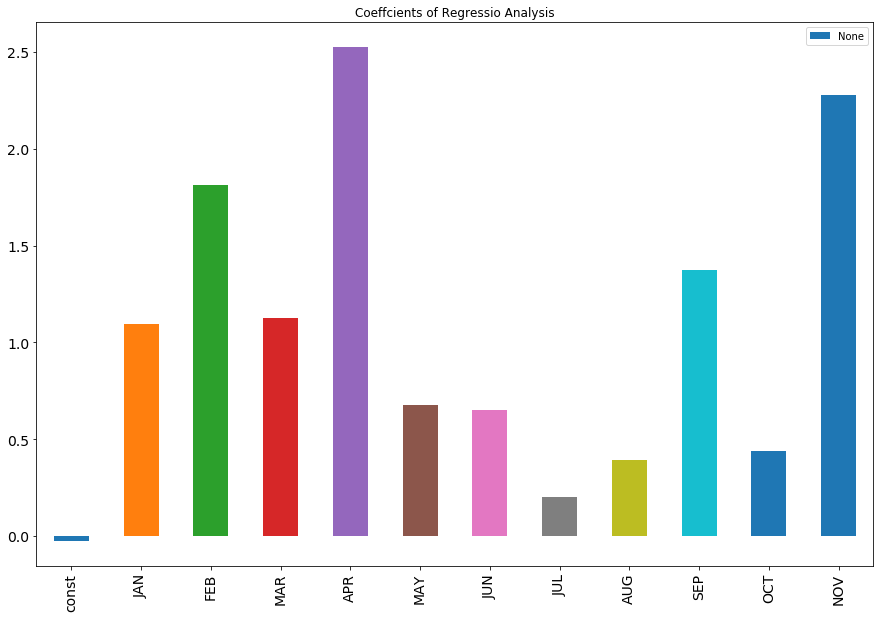

In [122]:
model11.params.plot(kind='bar', title ="Coeffcients of Regressio Analysis", figsize=(15, 10), legend=True, fontsize=14);

Looking at the model parameters we can see, month of April/November has the highest coefficient while July has the least coefficient. This shows possibility of higher return in months with higher coefficient and vice versa. This outcome is consistent with our analysis on average monthly return of the market bar chart presented at the beginning of this article.   

It is important to note during this study; the remainder component of seasonality has not been studied because it requires more in-depth statistical analysis which is outside the scope of this study. 
Now let's see how market reacted in 2018 so far:

[*********************100%***********************]  1 of 1 downloaded


C:\Users\anejad\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  # This is added back by InteractiveShellApp.init_path()


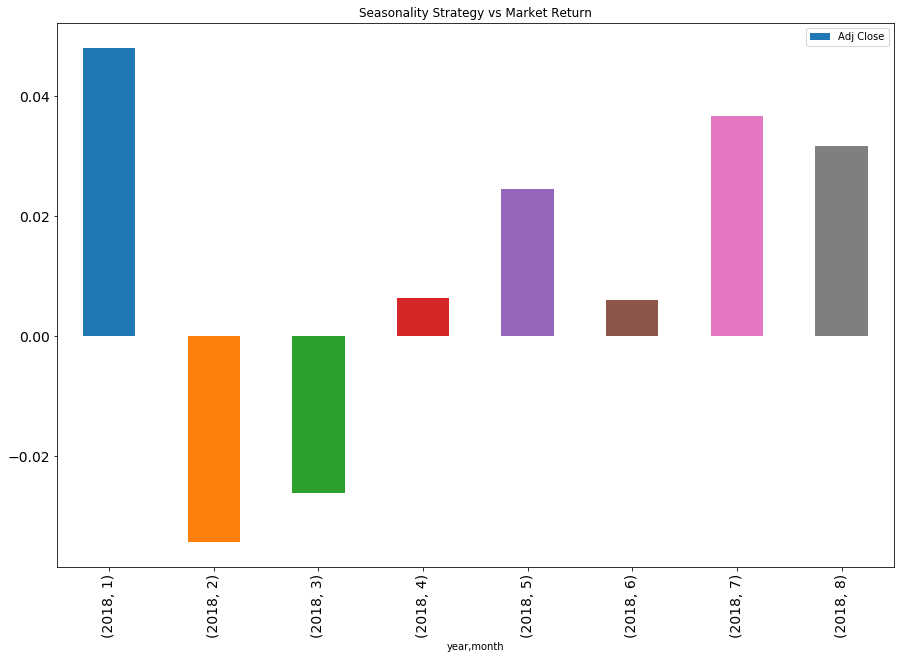

In [127]:
start = '2018-01-01'
end = '2018-09-01'
Symbol='SPY'

Data = yf.download(Symbol, start, end)
SPY_2018=Data['Adj Close']


r_2018 = SPY_2018.pct_change()

Monthly_Returns_2018=r_2018.groupby((r_2018.index.year.rename('year'), r_2018.index.month.rename('month'))).sum()

Monthly_Returns_2018.plot(kind='bar', title ="Seasonality Strategy vs Market Return", figsize=(15, 10), legend=True, fontsize=14)